In [ ]:
import pandas as pd 
import numpy as np 
import torch 
import matplotlib.pyplot as plt 
import seaborn as sns;sns.set_theme()
import json
from matplotlib.ticker import FuncFormatter
from utils import *

# Best and final epoch performance

In [2]:
# Best

cost_coef_list = [0.05, 0.1, 0.15]
T = 100

for cost_coef in cost_coef_list:
    df = pd.read_csv("result/synthetic_nov_c{}_final.csv".format(cost_coef), index_col=0)
    
    print(cost_coef)    
    print("best epoch")
    for col in df.columns[1:]:
        best_value = []
        for rep in range(10):
            best_value.append(df.loc[rep*T:(rep+1)*T, col].max())
        best_value = np.array(best_value)
        print(col, "{:.2f}, {:.2f}".format(best_value.mean(), best_value.std()))

    print("\nfinal epoch")
    final_epoch_perf = df.query("epoch == @T-1")
    # print("{:.3f}, {:.3f}".format(final_epoch_perf.mean(), final_epoch_perf.std()))
    for col in df.columns[1:]:
        print(col, "{:.2f}, {:.2f}".format(final_epoch_perf[col].mean(), final_epoch_perf[col].std()))
        
    print("\n")

0.05
best epoch
spg 5.09, 0.06
e2e 2.35, 0.07
vani 2.58, 0.03

final epoch
spg 5.09, 0.06
e2e 2.24, 0.09
vani 2.57, 0.03


0.1
best epoch
spg 5.14, 0.04
e2e 2.48, 0.06
vani 2.66, 0.04

final epoch
spg 5.13, 0.04
e2e 2.48, 0.06
vani 2.61, 0.01


0.15
best epoch
spg 5.14, 0.05
e2e 2.59, 0.05
vani 2.73, 0.04

final epoch
spg 5.11, 0.06
e2e 2.58, 0.05
vani 2.63, 0.02




# Plot Softmax and Noisy manipulation

In [3]:
df_soft = pd.read_csv("result/synthetic_nov_softmax.csv", index_col=0)

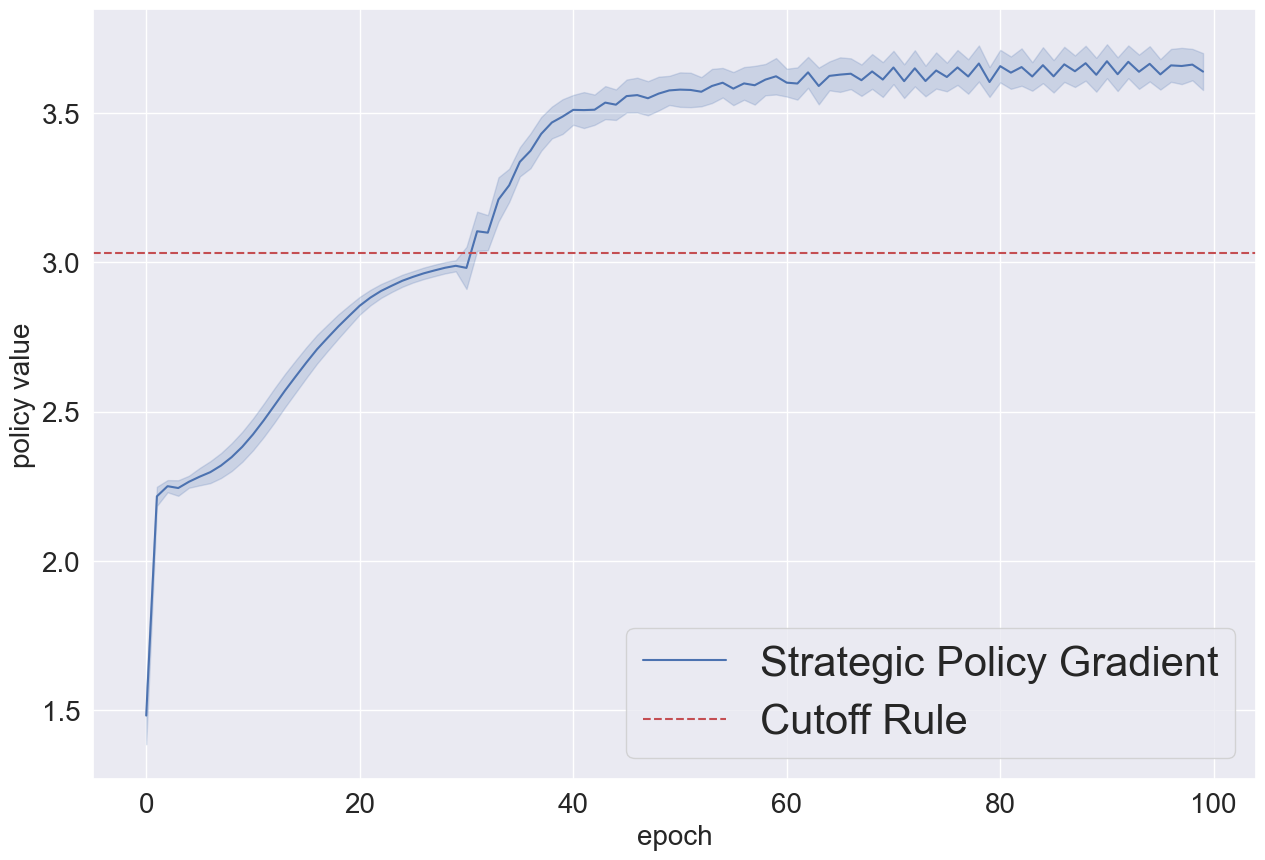

In [4]:
plt.figure(figsize=(15, 10))
sns.lineplot(data = df_soft, x = "epoch", y = "spg", label="Strategic Policy Gradient", errorbar=('se', 1))
plt.axhline(y=3.031, color='r', linestyle='--', label='Cutoff Rule')


plt.legend(loc="lower right", fontsize=30)
plt.xlabel("epoch", fontsize=20)
plt.ylabel("policy value", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("imgs/synthetic_policy_curve_softmax.pdf")

In [5]:
df_noisy = pd.read_csv("result/synthetic_nov_noisy.csv", index_col=0)

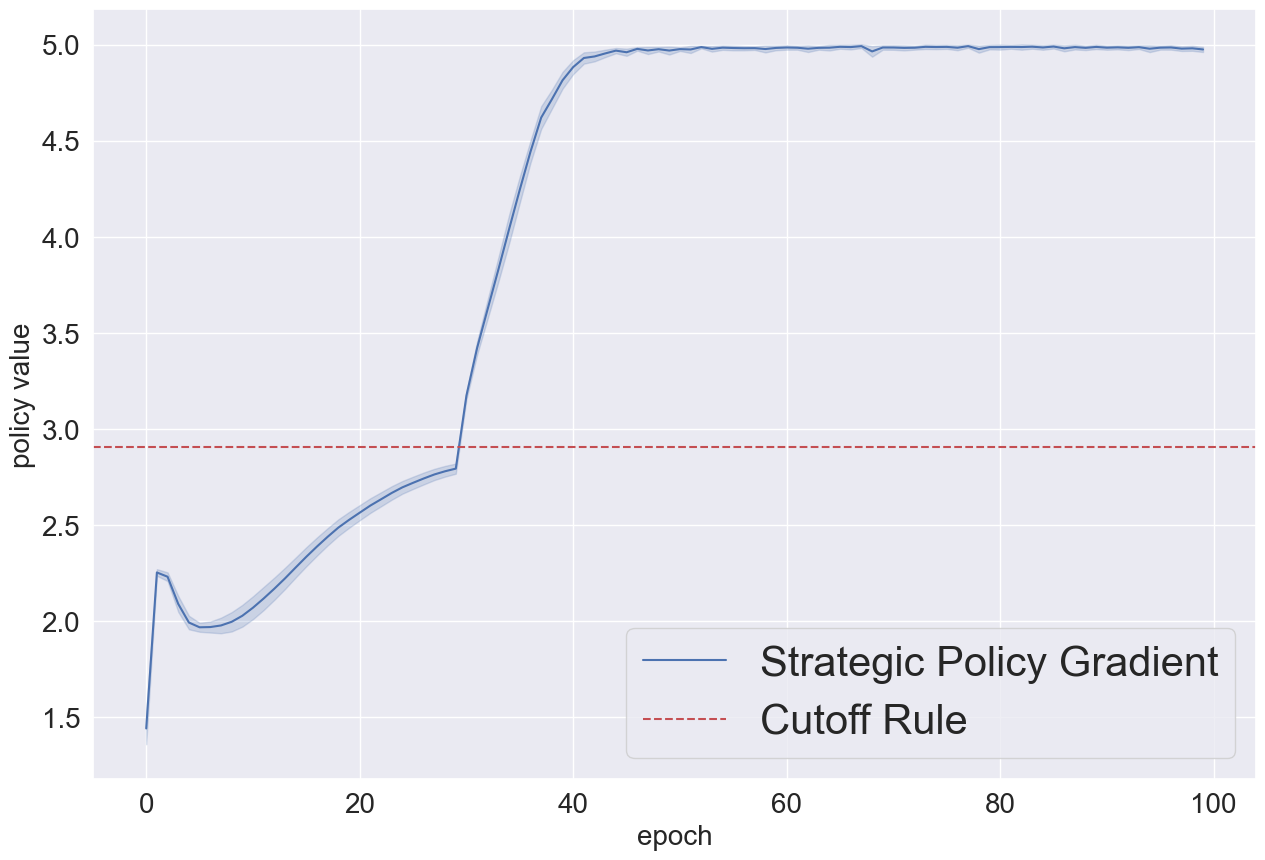

In [6]:
plt.figure(figsize=(15, 10))
sns.lineplot(data = df_noisy, x = "epoch", y = "spg", label="Strategic Policy Gradient", errorbar=('se', 1))
plt.axhline(y=2.905, color='r', linestyle='--', label='Cutoff Rule')

plt.legend(loc="lower right", fontsize=30)
plt.xlabel("epoch", fontsize=20)
plt.ylabel("policy value", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("imgs/synthetic_policy_curve_noisy.pdf")

# Plot standard policy curve

In [7]:
# our method
df_new = pd.read_csv("result/synthetic_nov_c0.1_final.csv", index_col=0)
df_new

,epoch,spg,e2e,vani
0,0,0.996582,1.013799,1.238812
1,1,2.040425,2.040457,2.386607
2,2,2.177582,2.187309,2.392658
3,3,2.113725,2.130386,2.280182
4,4,1.992121,2.010120,2.136100
...,...,...,...,...
995,95,5.178805,2.357754,2.579425
996,96,5.195343,2.357526,2.579138
997,97,5.180492,2.357538,2.579370
998,98,5.195450,2.358034,2.580613


In [8]:
cutoff_cv_list = torch.load("result/synthetic_cutoff_c0.1_final.pkl")
sum(cutoff_cv_list)/len(cutoff_cv_list)

2.650325059890747

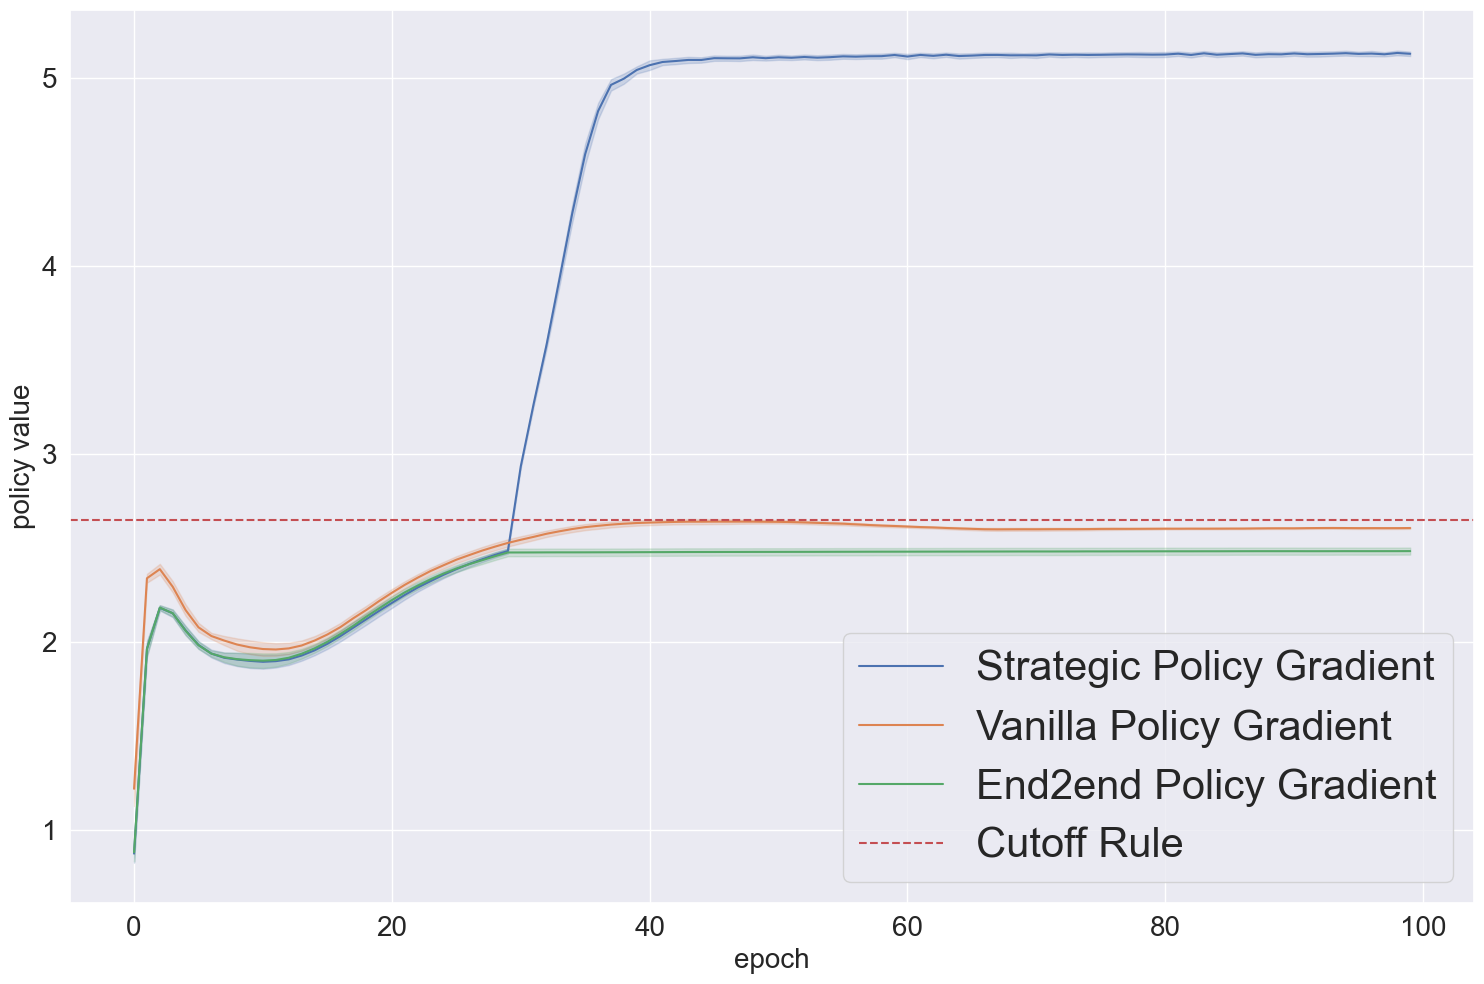

In [9]:
plt.figure(figsize=(15, 10))
sns.lineplot(data = df_new, x = "epoch", y = "spg", label="Strategic Policy Gradient", errorbar=('se', 1))
sns.lineplot(data = df_new, x = "epoch", y = "vani", label="Vanilla Policy Gradient", errorbar=('se', 1))
sns.lineplot(data = df_new, x = "epoch", y = "e2e", label="End2end Policy Gradient", errorbar=('se', 1))
plt.axhline(y= 2.650, color='r', linestyle='--', label='Cutoff Rule')


plt.legend(loc="lower right", fontsize=30)
plt.xlabel("epoch", fontsize=20)
plt.ylabel("policy value", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.savefig("imgs/synthetic_policy_curve_learn_cate_mac_cost_coef_0.1.pdf")

# u distribution after manipulation 


In [10]:
torch.manual_seed(1)

dim_v = 20
card_u = 5
beta = torch.tensor(list(np.linspace(-5, 5, card_u)) + list(np.random.normal(0, 1, size = (dim_v,))), dtype=torch.float32).view(-1, 1)
trans = torch.rand((dim_v, card_u), dtype=torch.float32)

T = 100
n = 3000
n_eval = 100000
repeat_num = 5

# fix samples for policy eval 
u, v = x_generate(n_eval, dim_v, trans)

In [11]:
vani_model = torch.load("models/vani_model_pi_cc_0.1.pkl", map_location=torch.device('cpu'))
stra_model = torch.load("models/model_pi_cc_0.1.pkl", map_location=torch.device('cpu'))
e2e_model = torch.load("models/e2e_model_pi_cc_0.1.pkl", map_location=torch.device('cpu'))

In [12]:
cost_coef = 0.1

_, u_category_vani, u_shift_vani = manipulation(u, v, u.shape[0], card_u, vani_model, c=cost_coef)        
_, u_category_stra, u_shift_stra = manipulation(u, v, u.shape[0], card_u, stra_model, c=cost_coef)        
_, _, u_category_e2e, u_shift_e2e = manipulation_theta(u, v, u.shape[0], card_u, e2e_model, c=cost_coef)        
u_shift_cate = manipulation_cutoff(u, v, u.shape[0], card_u, beta=beta, c=cost_coef)    
    
u_prime_vani = u_category_vani.reshape(-1)
u_prime_e2e = u_category_e2e.reshape(-1)
u_prime_stra = u_category_stra.reshape(-1)
u_prime_cate = u_shift_cate.argmax(dim=1).reshape(-1)

In [13]:
u_initial = u.argmax(dim=1).reshape(-1)

method_names = ["Initial", "CATE>0", "Vanilla", "End2end", "Strategic"]
u_s = [u_initial, u_prime_cate, u_prime_vani, u_prime_e2e, u_prime_stra]
name_col = []
u_col = []

for i in range(len(method_names)):
    name_col += [method_names[i]]*len(u_prime_vani)
    u_col += u_s[i].tolist()

u_df = pd.DataFrame(np.array([name_col, u_col]).T, columns = ["method", "u"])
u_df["u"] = u_df["u"].astype(int)

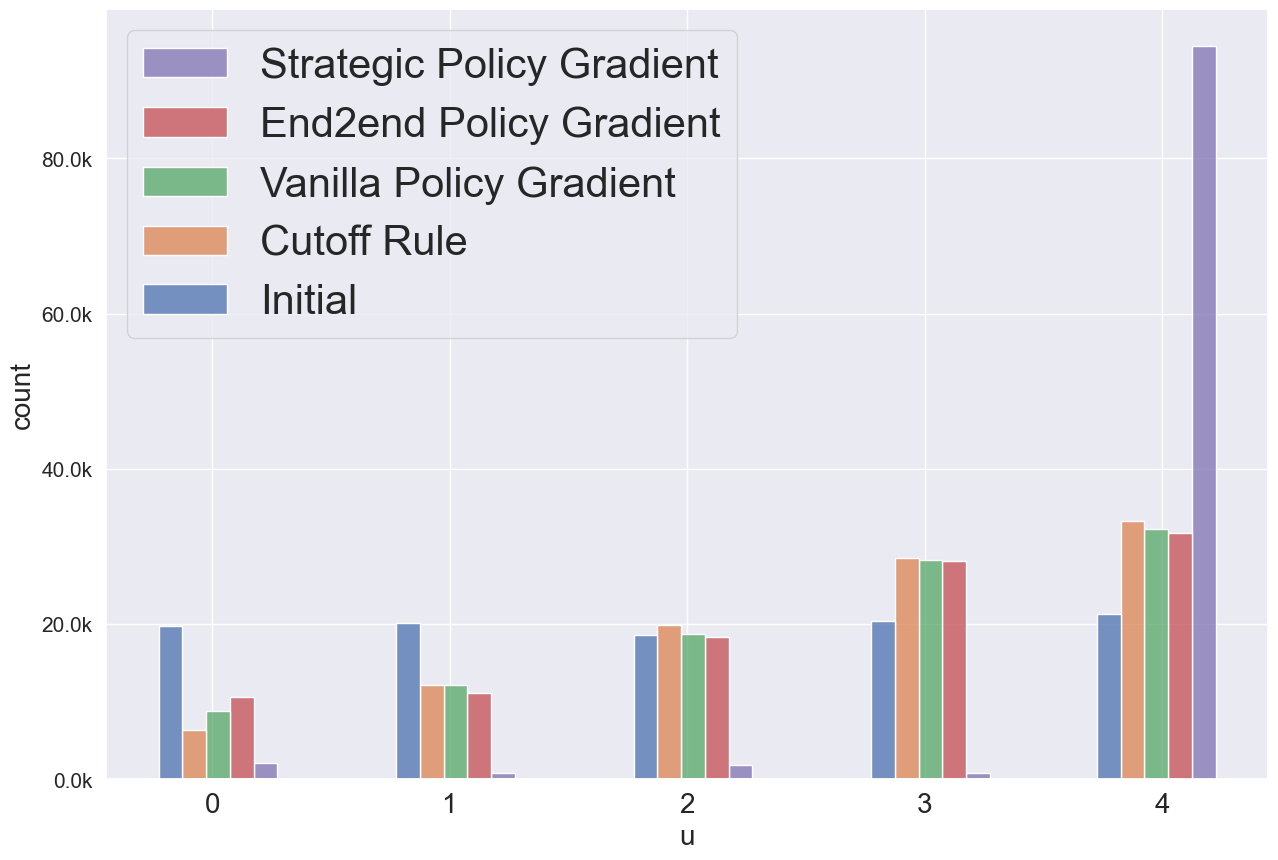

In [14]:
plt.figure(figsize=(15, 10))
ax = sns.histplot(data = u_df, x = "u", hue = "method", multiple="dodge", stat="count", shrink = 10, )

legend_labels = ["Strategic Policy Gradient", "End2end Policy Gradient", "Vanilla Policy Gradient", "Cutoff Rule", "Initial"]

def trans_thous(x, pos):
    return f'{x/1000}k'

plt.gca().yaxis.set_major_formatter(FuncFormatter(trans_thous))

# Add the custom legend
plt.legend(labels=legend_labels, fontsize=30)
plt.xlabel("u", fontsize=20)
plt.xticks(ticks = range(card_u), fontsize=20)
plt.ylabel("count", fontsize=20)
plt.yticks(fontsize=15)

plt.savefig("imgs/synthetic-u_distribution.pdf")

# Training Curve

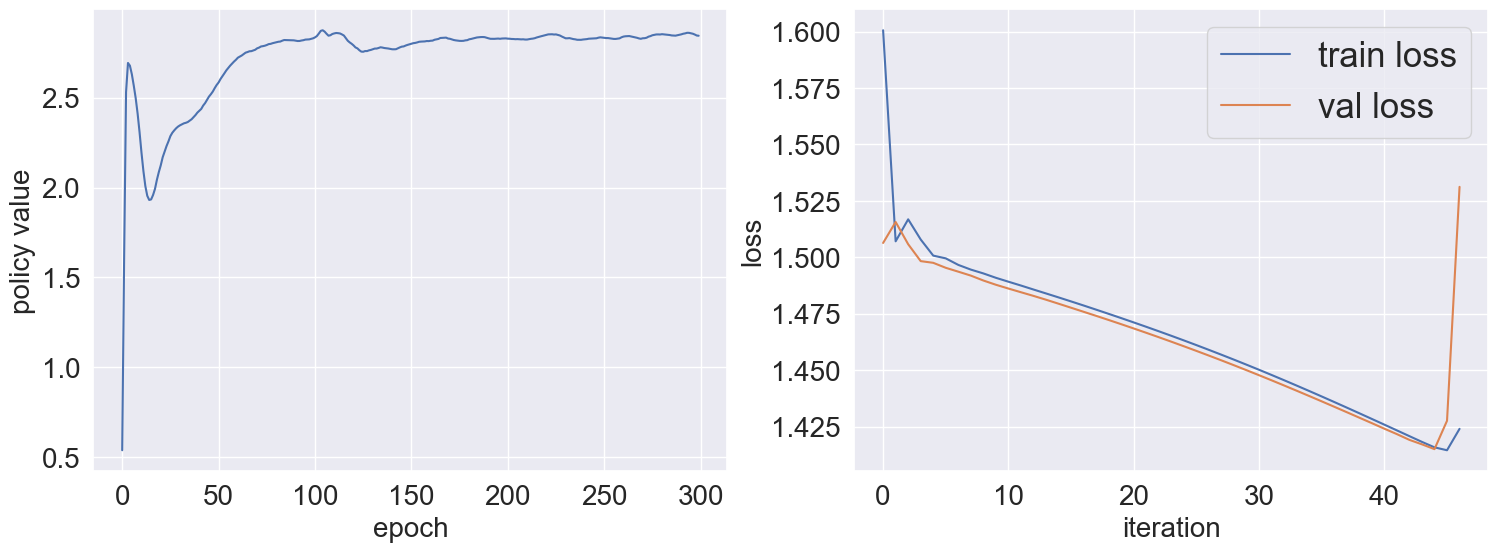

In [15]:

seq_revenue, seq_loss, seq_val = torch.load("result/instance_e2e_curve.pkl")
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.plot(seq_revenue)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("epoch", fontsize=20)
plt.ylabel("policy value", fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(seq_loss, label='train loss')
plt.plot(seq_val, label='val loss')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("iteration", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.legend(fontsize=25)

plt.savefig("imgs/instance_e2e.pdf")    

plt.show()        


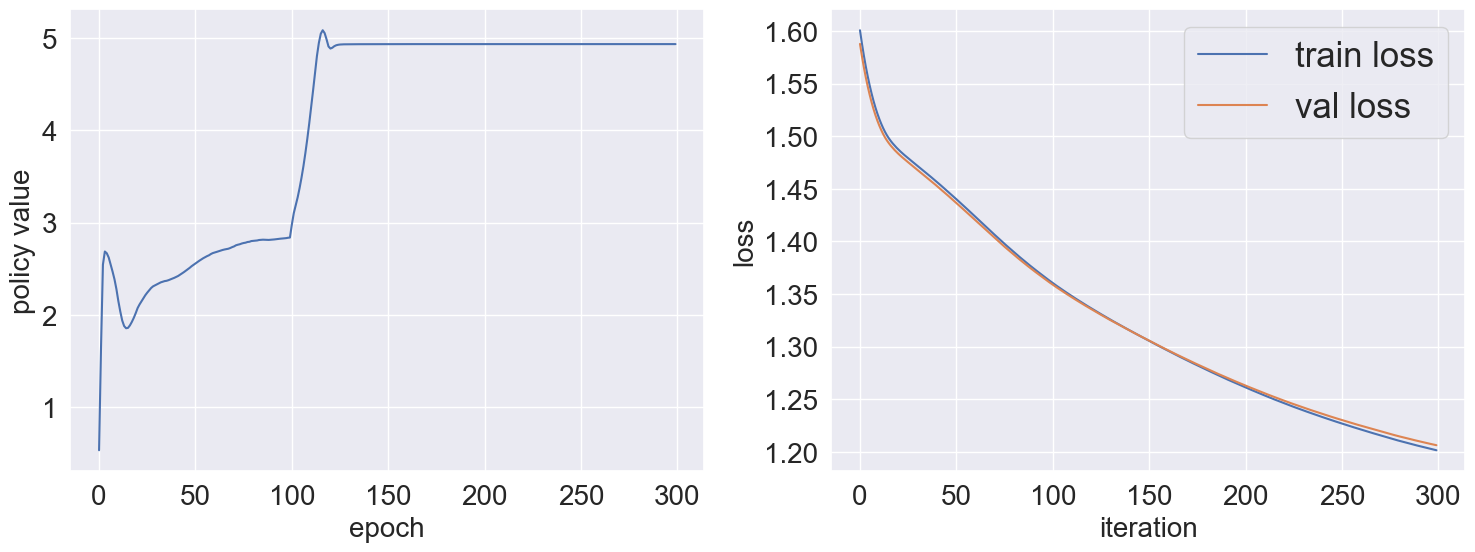

In [16]:

seq_revenue, seq_loss, seq_val = torch.load("result/instance_spg_curve.pkl")

plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.plot(seq_revenue)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("epoch", fontsize=20)
plt.ylabel("policy value", fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(seq_loss, label='train loss')
plt.plot(seq_val, label='val loss')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("iteration", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.legend(fontsize=25)     

plt.savefig("imgs/instance_spg.pdf")    
plt.show()        


# Coarsen Discretization


In [17]:
coarse_result = torch.load("result/coarse_spg_cv_list_true_2-10card50_new.pkl", map_location="cpu")

T = 150
repetition = 10 
epoch = list(range(T)) * repetition

coarse_pv_list = []
for i in range(5):
    policy_value_curve_list = []
    for j in range(repetition*i, repetition*(i+1)):
        policy_value_curve_list.extend(coarse_result[j][0])
    coarse_pv_list.append(policy_value_curve_list)

df = pd.DataFrame({"epoch":epoch})
card_u_list = [10, 5, 4, 3, 2]
for i in range(5):
    df[str(card_u_list[i])] = coarse_pv_list[i]    

In [18]:
df

,epoch,10,5,4,3,2
0,0,0.732183,0.648622,0.714979,0.633401,1.133601
1,1,1.365595,1.381471,1.606421,1.651792,1.665105
2,2,1.860900,1.885237,1.988673,2.215750,1.964327
3,3,2.169109,2.218204,2.264998,2.480548,2.081066
4,4,2.280616,2.316775,2.363716,2.550767,2.122736
...,...,...,...,...,...,...
1495,145,4.612650,3.867415,3.733530,3.191936,2.562584
1496,146,4.616499,3.885095,3.755112,3.234177,2.525780
1497,147,4.612558,3.869097,3.732095,3.189072,2.561199
1498,148,4.617476,3.883933,3.756512,3.233968,2.525569


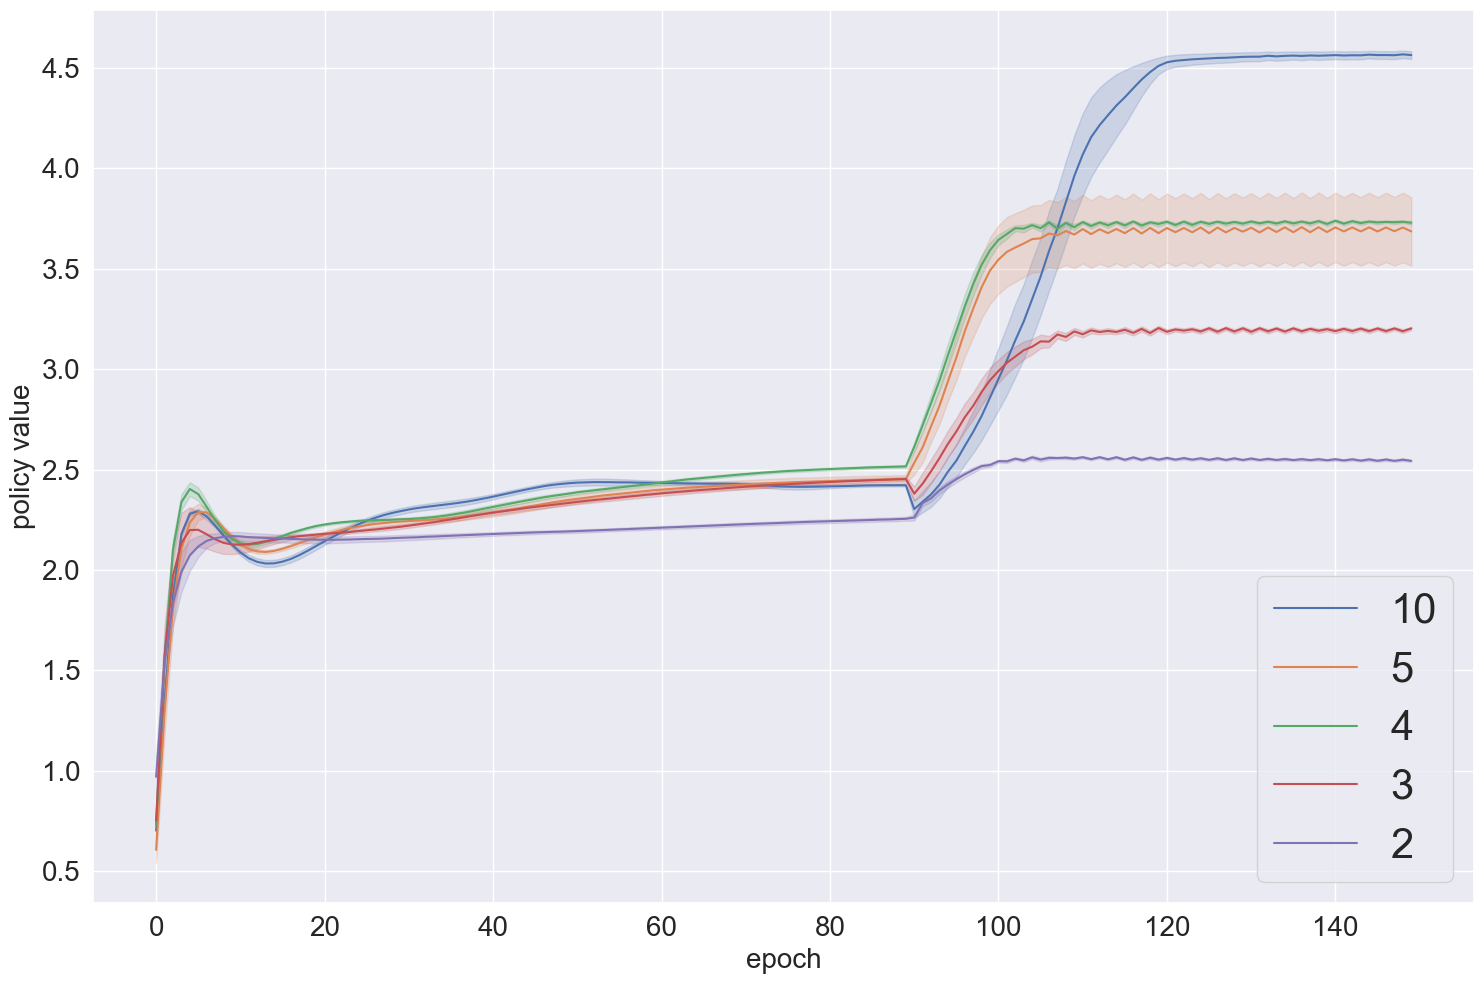

In [19]:
plt.figure(figsize=(15, 10))
for card_u in card_u_list:
    sns.lineplot(data = df, x = "epoch", y = str(card_u), label=str(card_u), errorbar=('se', 1))


plt.legend(loc="lower right", fontsize=30)
plt.xlabel("epoch", fontsize=20)
plt.ylabel("policy value", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.savefig("imgs/synthetic_coarse_true_card_50.pdf")

In [20]:
# card_u 15
coarse_result = torch.load("result/coarse_spg_cv_list_true_2-10card15_new.pkl", map_location="cpu")
len(coarse_result)

epoch = list(range(T)) * repetition

coarse_pv_list = []
for i in range(5):
    policy_value_curve_list = []
    for j in range(repetition*i, repetition*(i+1)):
        policy_value_curve_list.extend(coarse_result[j][0])
    coarse_pv_list.append(policy_value_curve_list)
        
df = pd.DataFrame({"epoch":epoch})
card_u_list = [10, 5, 4, 3, 2]
for i in range(5):
    df[str(card_u_list[i])] = coarse_pv_list[i]    

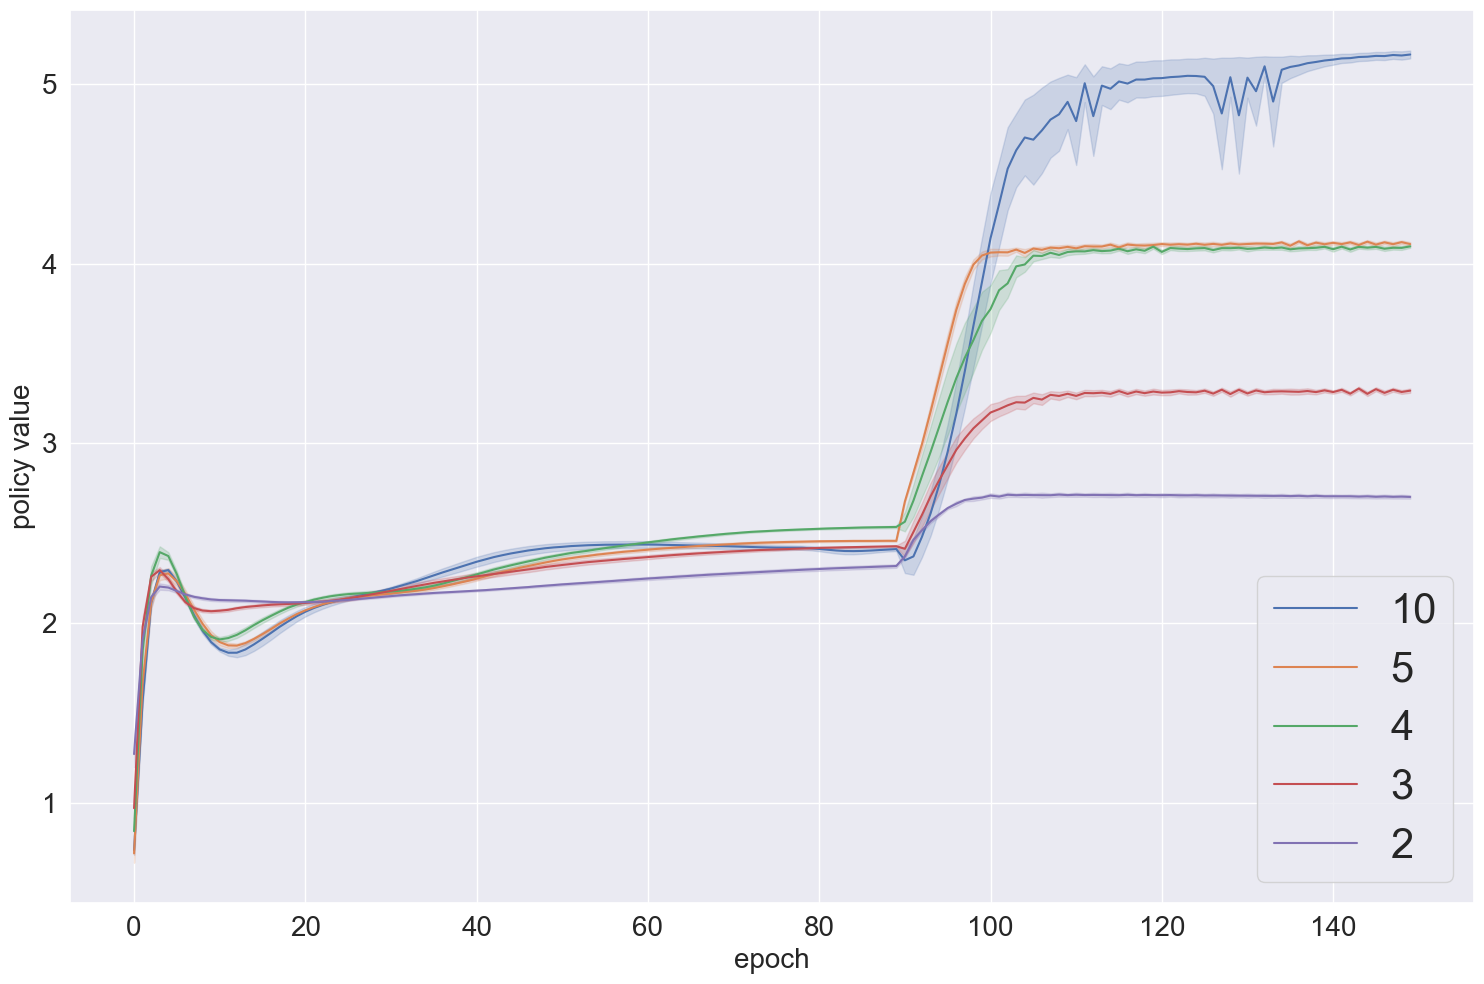

In [21]:
plt.figure(figsize=(15, 10))
for card_u in card_u_list:
    sns.lineplot(data = df, x = "epoch", y = str(card_u), label=str(card_u), errorbar=('se', 1))

plt.legend(loc="lower right", fontsize=30)
plt.xlabel("epoch", fontsize=20)
plt.ylabel("policy value", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.savefig("imgs/synthetic_coarse_true_card_15.pdf")

# GP classifier

In [22]:
df_gp = pd.read_csv("result/GP_coef_0.1.csv", index_col=0)
df_mlp = pd.read_csv("result/synthetic_nov_forGP_coef_0.1.csv", index_col=0)

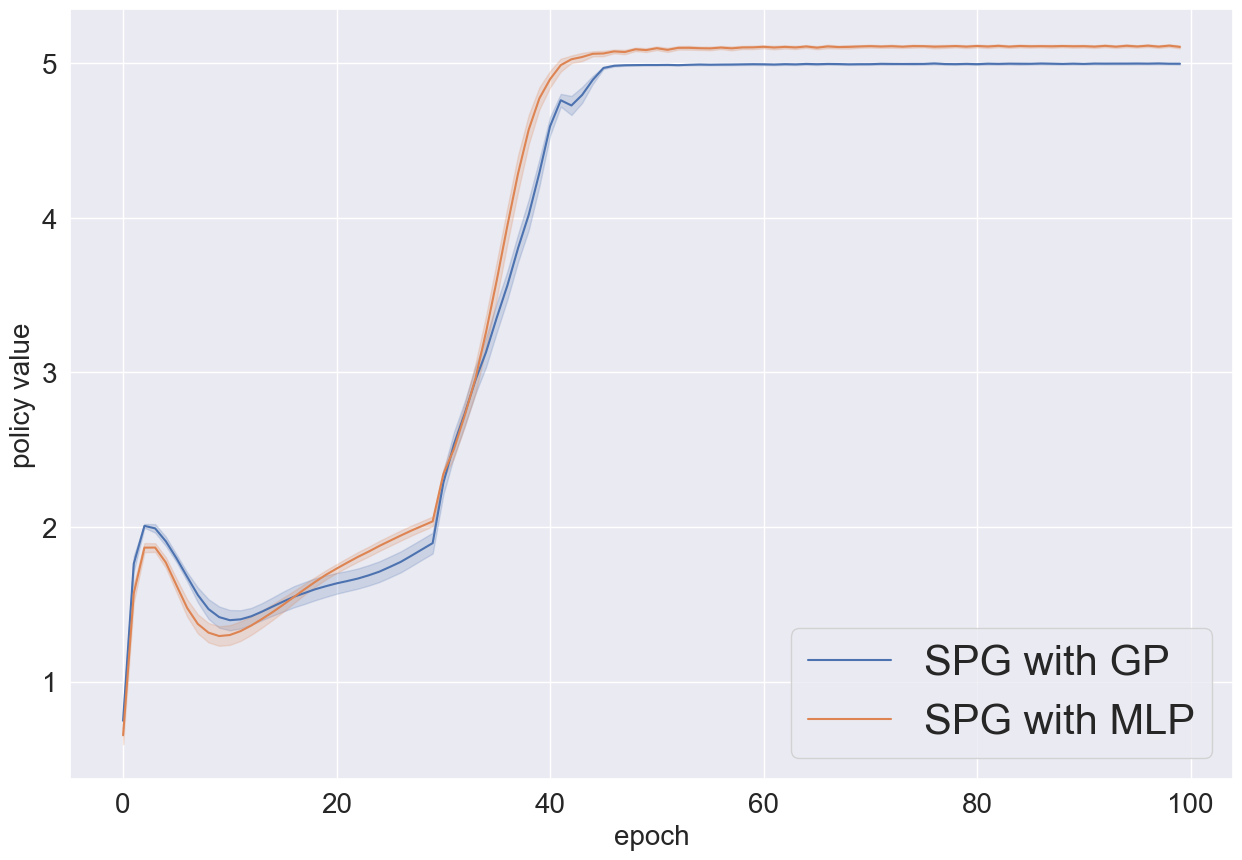

In [23]:
plt.figure(figsize=(15, 10))
sns.lineplot(data = df_gp, x = "epoch", y = "spg", label="SPG with GP", errorbar=('se', 1))
sns.lineplot(data = df_mlp, x = "epoch", y = "value", label="SPG with MLP", errorbar=('se', 1))

plt.legend(loc="lower right", fontsize=30)
plt.xlabel("epoch", fontsize=20)
plt.ylabel("policy value", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("imgs/synthetic_gp.pdf")

In [24]:
loss_gp = pd.read_csv("result/GP_train_curve_coef_0.1.csv", index_col=0)
loss_mlp = pd.read_csv("result/synthetic_train_curve_forGP_coef_0.1.csv", index_col=0)

In [25]:
loss_gp

,epoch,train
0,0,1.868419
1,1,1.850214
2,2,1.828596
3,3,1.808576
4,4,1.788535
...,...,...
2995,295,1.156217
2996,296,1.156186
2997,297,1.155978
2998,298,1.156157


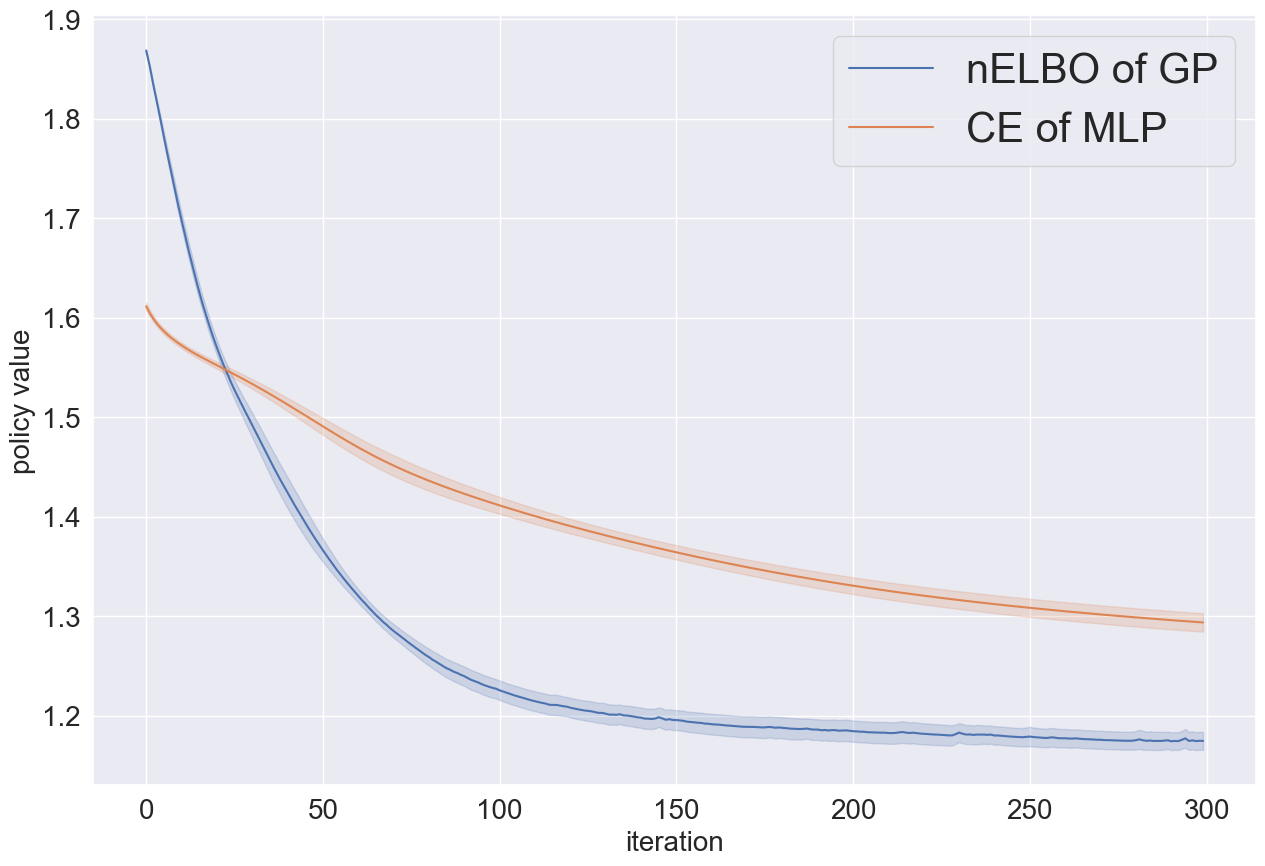

In [26]:
plt.figure(figsize=(15, 10))
sns.lineplot(data = loss_gp, x = "epoch", y = "train", label="nELBO of GP", errorbar=('se', 1))
sns.lineplot(data = loss_mlp, x = "epoch", y = "loss", label="CE of MLP", errorbar=('se', 1))

plt.legend(loc="upper right", fontsize=30)
plt.xlabel("iteration", fontsize=20)
plt.ylabel("policy value", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("imgs/synthetic_gp_train_curve.pdf")